# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
SOLVER = 'liblinear' 
PENALTY = "l2"


!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt
!python3 -m pip install prettytable

import os
import sys
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict

import sklearn.exceptions
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 

import collections
import matplotlib.pyplot as plt
import pylab as pl


from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import punkt
stop_words = stopwords.words('english')

from tqdm.notebook import tqdm
import collections
from prettytable import PrettyTable


print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:

verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:
cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values

------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

# GloVE

## Download and Load GloVe

In [7]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


## GloVe Train & Predict

In [8]:
cls = 'CR-00-00-00-00'



# Train and Test Split
p = len(X) // 10 * 9
train_text = X[:p]
test_text = X[p:]


print("Checkpoint1 - Data Read Complete")


hit = 0
all_words = 0
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    global hit, all_words
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    hit += len(M)
    all_words += len(words)
    
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_text)]

print('Mean Train Word Hit Rate(\%)', hit / all_words * 100)
hit = 0
all_words = 0

xtest_glove = [sent2vec(x) for x in tqdm(test_text)]
print('Mean Test Word Hit Rate(\%)', hit / all_words * 100)

print('Checkpoint2 -Normalized Vector for Sentences are created')

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced')

train_target = Y[:p]
test_target = Y[p:]

model.fit(xtrain_glove, train_target)
preds = model.predict(xtest_glove)

print(preds)
accuracy = accuracy_score(test_target, preds)
precision, recall, fscore, support = score(test_target, preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Checkpoint1 - Data Read Complete



Mean Train Word Hit Rate(\%) 99.58181372991224



Mean Test Word Hit Rate(\%) 99.61077662227088
Checkpoint2 -Normalized Vector for Sentences are created
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0.]
accuracy: 0.875
precision: [0.98518519 0.51219512]
recall: [0.86928105 0.91304348]
fscore: [0.92361111 0.65625   ]
support: [153  23]


## GloVE + Logistic Regression on CR-00-00-00-00

In [9]:

verbose = False
    
numdoc = defaultdict()

classifier = defaultdict()

    
def predict_by_class_glove(dfset: defaultdict,cls: str) -> float:
    global PENALTY, SOLVER
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)
    
    
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    print('data set size', len(X_glove))
    numdoc[cls] = len(X_glove)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    print('Checkpoint2 -Normalized Vector for Sentences are created')
    


    for train_index, test_index in kfold.split(X_glove, Y):

        X_train, X_test = X_glove[train_index], X_glove[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Scikit-Learn
        classifier[cls] = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000)
        classifier[cls].fit(X_train, Y_train)
        out = classifier[cls].predict(X_test)
        prob = classifier[cls].predict_proba(X_test)[:,1]
        
        

        #print(len(out))
        i = 0
        for x in test_index:
            preds[x] = out[i]
            probs[x] = prob[i]
            i += 1
            
        #print(preds)

        n_iter += 1
        
    custom_logloss = np.round(log_loss(Y, probs), 4)
    custom_brierloss = np.round(brier_score_loss(Y, probs), 4)
    print('logloss:', custom_logloss)
    print('brierloss: ',custom_brierloss)
    
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall:   tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)
    
    
    return (accuracy, precision[1], recall[1], fscore[1], support[1], custom_logloss, custom_brierloss)



#cls = 'BE-00-00-00-00'
cls = 'CR-00-00-00-00'
predict_by_class_glove(dfset, cls)


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
Checkpoint2 -Normalized Vector for Sentences are created
logloss: 0.4172
brierloss:  0.127


(0.8577, 0.5692, 0.8576, 0.6843, 302, 0.4172, 0.127)

## GloVe GridSearch

In [10]:
verbose = False
numdoc = defaultdict()
classifier = defaultdict()

    
def predict_by_class_glove_grid(dfset: defaultdict,cls: str) -> float:
    global PENALTY, SOLVER
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))
    kfold = KFold(n_splits=10)
    print('data set size', len(X_glove))
    numdoc[cls] = len(X_glove)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)

    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    best_c = 0
    
    best_logloss = 1
    best_brierloss = 1
    
    model = None


    for reg in range(-8, 1):
        
        c = 1.0/2.0**reg

        model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000, C = c)
        
        for train_index, test_index in kfold.split(X_glove, Y):
            X_train, X_test = X_glove[train_index], X_glove[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index]
            model.fit(X_train, Y_train)
            out = model.predict(X_test)
            prob = model.predict_proba(X_test)[:,1]

            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

            
        custom_logloss = np.round(log_loss(Y, probs), 4)
        custom_brierloss = np.round(brier_score_loss(Y, probs), 4)  
        
        c_list.append(reg)
        loss_list.append(custom_logloss)
        print('C:', c, end=' ')
        print(custom_logloss)

        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall:   tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)

#        if best_recall < recall[1]:
        if best_logloss > custom_logloss:
            best_logloss = custom_logloss
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            best_c = c
        if best_brierloss > custom_brierloss:
            best_brierloss = custom_brierloss
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support, best_logloss, best_brierloss, best_c, numdoc[cls])




------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
C: 256.0 0.3041
C: 128.0 0.3024
C: 64.0 0.3023
C: 32.0 0.3056
C: 16.0 0.3136
C: 8.0 0.3279
C: 4.0 0.3493
C: 2.0 0.3788
C: 1.0 0.4172
(0.8749, 0.6106, 0.8411, 0.7075, 302, 0.3023, 0.0907, 64.0, 1679)


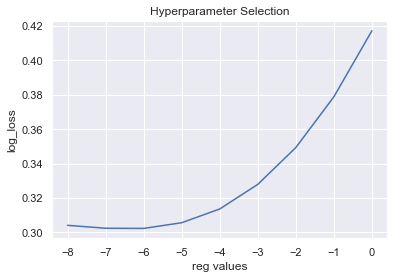

64.0


In [11]:
c_list = []
loss_list = []

cls = 'CR-00-00-00-00'
print(predict_by_class_glove_grid(dfset, cls))



# plotting the points  
plt.plot(range(-8,1), loss_list)  
plt.xlabel('reg values') 
plt.ylabel('log_loss') 
plt.title('Hyperparameter Selection') 
plt.show() 
print(classifier[cls].C)

# Entire Data 

## Build Models and Calculating Accuracies

In [12]:


class_list = df.columns[2:]
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in tqdm(class_list):
    ret = predict_by_class_glove_grid(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

Index(['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00',
       'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00',
       'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00',
       'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00',
       'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00',
       'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00',
       'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00',
       'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00',
       'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00'],
      dtype='object')



------------------------------------

0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848
C: 256.0 0.1996
C: 128.0 0.2026
C: 64.0 0.2108
C: 32.0 0.225
C: 16.0 0.2461
C: 8.0 0.2742
C: 4.0 0.3093
C: 2.0 0.3512
C: 1.0 0.4004
statistics (0.9302, 0.1304, 0.6667, 0.2182, 27, 0.1996, 0.0532, 256.0, 1848)



------------------------------------

0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590
C: 256.0 0.1664
C: 128.0 0.1666
C: 64.0 0.1697
C: 32.0 0.1754
C: 16.0 0.1839
C: 8.0 0.197
C: 4.0 0.2168
C: 2.0 0.2458
C: 1.0 0.2862
statistics (0.9396, 0.4909, 0.871, 0.6279, 93, 0.1664, 0.0465, 256.0, 1590)



------------------------------------

0.0    1058
1.0     106
Name: CO-00-00-00-00, dtype: int64
data set size 1164
C: 256.0 0.3081
C: 128.0 0.3049
C: 64.0 0.304
C: 32.0 0.3077
C: 16.0 0.3181
C: 8.0 0.3367
C: 4.0 0.3642
C: 2.0 0.4007
C: 1.0 0.4461
statistics (0.8935, 0.4521, 0.8019, 0.5782, 106, 0.304, 0.0877, 64.0, 1164)



------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
C: 256.0 0.3041
C: 128.0 0.3024
C: 64.0 0.3023
C: 32.0 0.3056
C: 16.0 0.3136
C: 8.0 0.3279
C: 4.0 0.3493
C: 2.0 0.3788
C: 1.0 0.4172
statistics (0.8749, 0.6106, 0.8411, 0.7075, 302, 0.3023, 0.0907, 64.0, 1679)



------------------------------------

0.0    1381
1.0      12
Name: CR-01-00-00-00, dtype: int64
data set size 1393
C: 256.0 0.2066
C: 128.0 0.2124
C: 64.0 0.2258
C: 32.0 0.2464
C: 16.0 0.2741
C: 8.0 0.309
C: 4.0 0.3508
C: 2.0 0.399
C: 1.0 0.4526
statistics (0.9296, 0.0222, 0.1667, 0.0392, 12, 0.2066, 0.054, 256.0, 1393)



------------------------------------

0.0    1389
1.0      13
Name: CR-04-00-00-00, dtype: int64
data set size 1402
C: 256.0 0.2624
C: 128.0 0.2721
C: 64.0 0.2865
C: 32.0 0.3053
C: 16.0 0.329
C: 8.0 0.3576
C: 4.0 0.3912
C: 2.0 0.4302
C: 1.0 0.4744
statistics (0.9158, 0.027, 0.2308, 0.0484, 13, 0.2624, 0.0685, 256.0, 1402)



------------------------------------

0.0    1393
1.0      11
Name: CR-06-00-00-00, dtype: int64
data set size 1404
C: 256.0 0.1545
C: 128.0 0.1657
C: 64.0 0.1815
C: 32.0 0.2026
C: 16.0 0.2304
C: 8.0 0.2655
C: 4.0 0.3083
C: 2.0 0.3588
C: 1.0 0.4167
statistics (0.9423, 0.0395, 0.2727, 0.069, 11, 0.1545, 0.042, 256.0, 1404)



------------------------------------

0.0    1958
1.0      11
Name: CR-10-00-00-00, dtype: int64
data set size 1969
C: 256.0 0.1737
C: 128.0 0.1839
C: 64.0 0.1978
C: 32.0 0.2172
C: 16.0 0.2428
C: 8.0 0.2742
C: 4.0 0.3117
C: 2.0 0.3557
C: 1.0 0.4065
statistics (0.9431, 0.019, 0.1818, 0.0345, 11, 0.1737, 0.0437, 256.0, 1969)



------------------------------------

0.0    1789
1.0      24
Name: ED-00-00-00-00, dtype: int64
data set size 1813
C: 256.0 0.1264
C: 128.0 0.1312
C: 64.0 0.1398
C: 32.0 0.1534
C: 16.0 0.173
C: 8.0 0.1997
C: 4.0 0.2343
C: 2.0 0.2777
C: 1.0 0.3309
statistics (0.963, 0.2133, 0.6667, 0.3232, 24, 0.1264, 0.029, 256.0, 1813)



------------------------------------

0.0    1866
1.0      78
Name: ES-00-00-00-00, dtype: int64
data set size 1944
C: 256.0 0.2141
C: 128.0 0.2108
C: 64.0 0.2122
C: 32.0 0.2198
C: 16.0 0.2345
C: 8.0 0.2565
C: 4.0 0.2858
C: 2.0 0.3226
C: 1.0 0.3675
statistics (0.9136, 0.2955, 0.8333, 0.4362, 78, 0.2108, 0.0622, 128.0, 1944)



------------------------------------

0.0    1866
1.0      10
Name: ES-01-00-00-00, dtype: int64
data set size 1876
C: 256.0 0.0877
C: 128.0 0.0983
C: 64.0 0.1131
C: 32.0 0.1327
C: 16.0 0.1585
C: 8.0 0.192
C: 4.0 0.2347
C: 2.0 0.2869
C: 1.0 0.3479
statistics (0.967, 0.0517, 0.3, 0.0882, 10, 0.0877, 0.0238, 256.0, 1876)



------------------------------------

0.0    1979
1.0      13
Name: ES-03-00-00-00, dtype: int64
data set size 1992
C: 256.0 0.2039
C: 128.0 0.2044
C: 64.0 0.2105
C: 32.0 0.2223
C: 16.0 0.24
C: 8.0 0.2639
C: 4.0 0.2934
C: 2.0 0.3284
C: 1.0 0.3698
statistics (0.9357, 0.0325, 0.3077, 0.0588, 13, 0.2039, 0.0505, 256.0, 1992)



------------------------------------

0.0    1685
1.0     357
Name: FA-00-00-00-00, dtype: int64
data set size 2042
C: 256.0 0.2564
C: 128.0 0.2575
C: 64.0 0.2611
C: 32.0 0.2679
C: 16.0 0.2785
C: 8.0 0.294
C: 4.0 0.3154
C: 2.0 0.3445
C: 1.0 0.3825
statistics (0.8991, 0.6538, 0.8992, 0.7571, 357, 0.2564, 0.0758, 256.0, 2042)



------------------------------------

0.0    2001
1.0      10
Name: FA-05-00-00-00, dtype: int64
data set size 2011
C: 256.0 0.138
C: 128.0 0.1493
C: 64.0 0.1651
C: 32.0 0.1852
C: 16.0 0.2101
C: 8.0 0.24
C: 4.0 0.2746
C: 2.0 0.3141
C: 1.0 0.3596
statistics (0.9582, 0.0256, 0.2, 0.0455, 10, 0.138, 0.0347, 256.0, 2011)



------------------------------------

0.0    1781
1.0      10
Name: FA-06-00-00-00, dtype: int64
data set size 1791
C: 256.0 0.1511
C: 128.0 0.1623
C: 64.0 0.1782
C: 32.0 0.1979
C: 16.0 0.2217
C: 8.0 0.2502
C: 4.0 0.2847
C: 2.0 0.3261
C: 1.0 0.3751
statistics (0.9531, 0.0375, 0.3, 0.0667, 10, 0.1511, 0.0382, 256.0, 1791)



------------------------------------

0.0    1927
1.0      41
Name: FA-07-00-00-00, dtype: int64
data set size 1968
C: 256.0 0.3277
C: 128.0 0.3285
C: 64.0 0.3337
C: 32.0 0.3437
C: 16.0 0.358
C: 8.0 0.3764
C: 4.0 0.3981
C: 2.0 0.4226
C: 1.0 0.4505
statistics (0.8613, 0.0857, 0.5854, 0.1495, 41, 0.3277, 0.0992, 256.0, 1968)



------------------------------------

0.0    1504
1.0      13
Name: GO-00-00-00-00, dtype: int64
data set size 1517
C: 256.0 0.2298
C: 128.0 0.2369
C: 64.0 0.2503
C: 32.0 0.2689
C: 16.0 0.2932
C: 8.0 0.3241
C: 4.0 0.3623
C: 2.0 0.4079
C: 1.0 0.4594
statistics (0.9288, 0.0202, 0.1538, 0.0357, 13, 0.2298, 0.0556, 256.0, 1517)



------------------------------------

0.0    1778
1.0     122
Name: HE-00-00-00-00, dtype: int64
data set size 1900
C: 256.0 0.1864
C: 128.0 0.1833
C: 64.0 0.1836
C: 32.0 0.1882
C: 16.0 0.1981
C: 8.0 0.215
C: 4.0 0.2409
C: 2.0 0.2776
C: 1.0 0.3261
statistics (0.9384, 0.5121, 0.8689, 0.6444, 122, 0.1833, 0.0501, 128.0, 1900)



------------------------------------

0.0    1582
1.0     550
Name: HO-00-00-00-00, dtype: int64
data set size 2132
C: 256.0 0.2193
C: 128.0 0.2206
C: 64.0 0.2229
C: 32.0 0.2284
C: 16.0 0.2395
C: 8.0 0.2583
C: 4.0 0.2868
C: 2.0 0.3265
C: 1.0 0.3775
statistics (0.9278, 0.8225, 0.9182, 0.8677, 550, 0.2193, 0.0606, 256.0, 2132)



------------------------------------

0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
data set size 1662
C: 256.0 0.2663
C: 128.0 0.2649
C: 64.0 0.267
C: 32.0 0.2736
C: 16.0 0.2863
C: 8.0 0.3069
C: 4.0 0.337
C: 2.0 0.3773
C: 1.0 0.4271
statistics (0.9031, 0.1371, 0.7059, 0.2297, 34, 0.2649, 0.0728, 128.0, 1662)



------------------------------------

0.0    1626
1.0      27
Name: HO-09-00-00-00, dtype: int64
data set size 1653
C: 256.0 0.1779
C: 128.0 0.1763
C: 64.0 0.1806
C: 32.0 0.1912
C: 16.0 0.2085
C: 8.0 0.2333
C: 4.0 0.2661
C: 2.0 0.3077
C: 1.0 0.358
statistics (0.9413, 0.1698, 0.6667, 0.2707, 27, 0.1763, 0.0459, 128.0, 1653)



------------------------------------

0.0    1928
1.0      36
Name: IM-00-00-00-00, dtype: int64
data set size 1964
C: 256.0 0.1226
C: 128.0 0.1283
C: 64.0 0.1381
C: 32.0 0.1521
C: 16.0 0.1712
C: 8.0 0.1964
C: 4.0 0.2289
C: 2.0 0.2697
C: 1.0 0.3198
statistics (0.9577, 0.2718, 0.7778, 0.4029, 36, 0.1226, 0.0327, 256.0, 1964)



------------------------------------

0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64
data set size 1429
C: 256.0 0.3778
C: 128.0 0.377
C: 64.0 0.3774
C: 32.0 0.3804
C: 16.0 0.3873
C: 8.0 0.3998
C: 4.0 0.4194
C: 2.0 0.4471
C: 1.0 0.4826
statistics (0.8279, 0.631, 0.7896, 0.7015, 366, 0.377, 0.1186, 128.0, 1429)



------------------------------------

0.0    1937
1.0      12
Name: MO-02-00-00-00, dtype: int64
data set size 1949
C: 256.0 0.1386
C: 128.0 0.1438
C: 64.0 0.1547
C: 32.0 0.1714
C: 16.0 0.1942
C: 8.0 0.224
C: 4.0 0.2613
C: 2.0 0.3069
C: 1.0 0.361
statistics (0.959, 0.0526, 0.3333, 0.0909, 12, 0.1386, 0.0319, 256.0, 1949)



------------------------------------

0.0    1116
1.0      13
Name: MO-07-00-00-00, dtype: int64
data set size 1129
C: 256.0 0.104
C: 128.0 0.1188
C: 64.0 0.1377
C: 32.0 0.1614
C: 16.0 0.1918
C: 8.0 0.2296
C: 4.0 0.2749
C: 2.0 0.3276
C: 1.0 0.3876
statistics (0.9601, 0.1522, 0.5385, 0.2373, 13, 0.104, 0.0295, 256.0, 1129)



------------------------------------

0.0    1095
1.0      11
Name: MO-10-00-00-00, dtype: int64
data set size 1106
C: 256.0 0.1898
C: 128.0 0.1981
C: 64.0 0.2129
C: 32.0 0.2342
C: 16.0 0.262
C: 8.0 0.2967
C: 4.0 0.3391
C: 2.0 0.3894
C: 1.0 0.4465
statistics (0.9385, 0.0328, 0.1818, 0.0556, 11, 0.1898, 0.0481, 256.0, 1106)



------------------------------------

0.0    1374
1.0      22
Name: RI-00-00-00-00, dtype: int64
data set size 1396
C: 256.0 0.375
C: 128.0 0.3687
C: 64.0 0.368
C: 32.0 0.3727
C: 16.0 0.3829
C: 8.0 0.3995
C: 4.0 0.4231
C: 2.0 0.4537
C: 1.0 0.4908
statistics (0.8481, 0.0343, 0.3182, 0.0619, 22, 0.368, 0.1013, 64.0, 1396)



------------------------------------

0.0    1027
1.0     230
Name: TO-00-00-00-00, dtype: int64
data set size 1257
C: 256.0 0.3706
C: 128.0 0.3685
C: 64.0 0.3659
C: 32.0 0.3652
C: 16.0 0.3696
C: 8.0 0.3812
C: 4.0 0.4013
C: 2.0 0.43
C: 1.0 0.4662
statistics (0.8369, 0.5358, 0.813, 0.6459, 230, 0.3652, 0.1148, 32.0, 1257)



------------------------------------

0.0    1746
1.0     260
Name: TR-00-00-00-00, dtype: int64
data set size 2006
C: 256.0 0.1923
C: 128.0 0.1918
C: 64.0 0.1926
C: 32.0 0.1963
C: 16.0 0.2046
C: 8.0 0.2197
C: 4.0 0.2436
C: 2.0 0.2781
C: 1.0 0.3244
statistics (0.9327, 0.6781, 0.9154, 0.7791, 260, 0.1918, 0.0525, 128.0, 2006)



------------------------------------

0.0    1805
1.0      22
Name: TR-01-00-00-00, dtype: int64
data set size 1827
C: 256.0 0.1534
C: 128.0 0.1547
C: 64.0 0.1606
C: 32.0 0.1701
C: 16.0 0.1835
C: 8.0 0.202
C: 4.0 0.2274
C: 2.0 0.2621
C: 1.0 0.3079
statistics (0.9568, 0.1724, 0.6818, 0.2752, 22, 0.1534, 0.0372, 256.0, 1827)



------------------------------------

0.0    1790
1.0      29
Name: TR-02-00-00-00, dtype: int64
data set size 1819
C: 256.0 0.2065
C: 128.0 0.2051
C: 64.0 0.2086
C: 32.0 0.2176
C: 16.0 0.2327
C: 8.0 0.2543
C: 4.0 0.2831
C: 2.0 0.3202
C: 1.0 0.3665
statistics (0.9274, 0.1295, 0.6207, 0.2143, 29, 0.2051, 0.0554, 128.0, 1819)



------------------------------------

0.0    1804
1.0      17
Name: TR-03-00-00-00, dtype: int64
data set size 1821
C: 256.0 0.1232
C: 128.0 0.1322
C: 64.0 0.1441
C: 32.0 0.1597
C: 16.0 0.1798
C: 8.0 0.2058
C: 4.0 0.2397
C: 2.0 0.2833
C: 1.0 0.3375
statistics (0.9539, 0.0964, 0.4706, 0.16, 17, 0.1232, 0.0327, 256.0, 1821)



------------------------------------

0.0    1795
1.0      20
Name: TR-04-00-00-00, dtype: int64
data set size 1815
C: 256.0 0.1374
C: 128.0 0.1333
C: 64.0 0.1347
C: 32.0 0.1421
C: 16.0 0.1562
C: 8.0 0.1782
C: 4.0 0.2092
C: 2.0 0.2508
C: 1.0 0.3048
statistics (0.9642, 0.1739, 0.6, 0.2697, 20, 0.1333, 0.0287, 128.0, 1815)



------------------------------------

0.0    1785
1.0      31
Name: TR-05-00-00-00, dtype: int64
data set size 1816
C: 256.0 0.1098
C: 128.0 0.1148
C: 64.0 0.1218
C: 32.0 0.1313
C: 16.0 0.1449
C: 8.0 0.1644
C: 4.0 0.1917
C: 2.0 0.2292
C: 1.0 0.2786
statistics (0.962, 0.2738, 0.7419, 0.4, 31, 0.1098, 0.0278, 256.0, 1816)



------------------------------------

0.0    1604
1.0     387
Name: WO-00-00-00-00, dtype: int64
data set size 1991
C: 256.0 0.3219
C: 128.0 0.322
C: 64.0 0.3235
C: 32.0 0.3281
C: 16.0 0.3385
C: 8.0 0.3568
C: 4.0 0.3847
C: 2.0 0.4223
C: 1.0 0.4686
statistics (0.8639, 0.6103, 0.8295, 0.7032, 387, 0.3219, 0.0988, 256.0, 1991)



------------------------------------

0.0    1607
1.0      10
Name: WO-03-00-00-00, dtype: int64
data set size 1617
C: 256.0 0.2454
C: 128.0 0.2414
C: 64.0 0.2458
C: 32.0 0.2596
C: 16.0 0.2833
C: 8.0 0.3167
C: 4.0 0.3597
C: 2.0 0.4108
C: 1.0 0.4671
statistics (0.9147, 0.0077, 0.1, 0.0143, 10, 0.2414, 0.0617, 128.0, 1617)



In [13]:
import pickle
with open("models_glove_l2_50d.pckl", "wb") as f:
    for val in classifier.items():
         pickle.dump(val, f)
            
            
with open("stats_glove_l2_50d.pckl", "wb") as f:
    for val in stat_dict.items():
         pickle.dump(val, f)

## C Values

In [14]:
for cls in class_list:
    print(classifier[cls].C)

256.0
256.0
64.0
64.0
256.0
256.0
256.0
256.0
256.0
128.0
256.0
256.0
256.0
256.0
256.0
256.0
256.0
128.0
256.0
128.0
128.0
256.0
128.0
256.0
256.0
256.0
64.0
32.0
128.0
256.0
128.0
256.0
128.0
256.0
256.0
128.0


## Distribution

In [22]:

t = PrettyTable(["class", "accuracy", "precision", "recall", "F1", "sup", "log_loss", "brier_loss", "C", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
t.align["log_loss"] = "r"
t.align["brier_loss"] = "r"
t.align["C"] = "r"

for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], v[5], v[6], v[7], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+--------+-----+----------+------------+-------+-------------+
|     class      | accuracy | precision | recall |   F1   | sup | log_loss | brier_loss |     C | |documents| |
+----------------+----------+-----------+--------+--------+-----+----------+------------+-------+-------------+
| BE-00-00-00-00 |   0.9302 |    0.1304 | 0.6667 | 0.2182 |  27 |   0.1996 |     0.0532 | 256.0 |     1848    |
| BU-00-00-00-00 |   0.9396 |    0.4909 |  0.871 | 0.6279 |  93 |   0.1664 |     0.0465 | 256.0 |     1590    |
| CO-00-00-00-00 |   0.8935 |    0.4521 | 0.8019 | 0.5782 | 106 |    0.304 |     0.0877 |  64.0 |     1164    |
| CR-00-00-00-00 |   0.8749 |    0.6106 | 0.8411 | 0.7075 | 302 |   0.3023 |     0.0907 |  64.0 |     1679    |
| CR-01-00-00-00 |   0.9296 |    0.0222 | 0.1667 | 0.0392 |  12 |   0.2066 |      0.054 | 256.0 |     1393    |
| CR-04-00-00-00 |   0.9158 |     0.027 | 0.2308 | 0.0484 |  13 |   0.2624 |     0.0685 | 256.0 |     14

## Plotting for Top10 classes

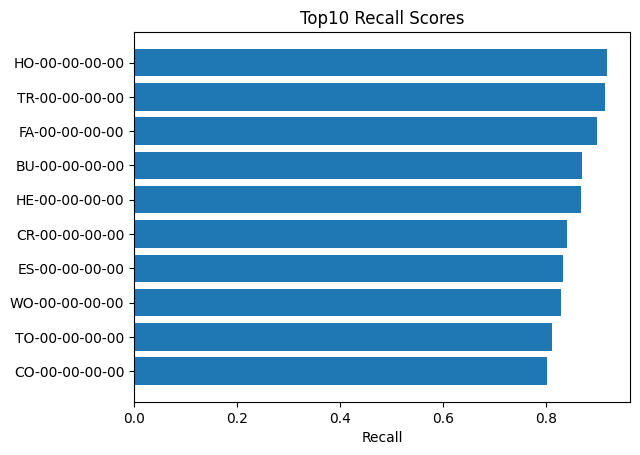

In [16]:


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

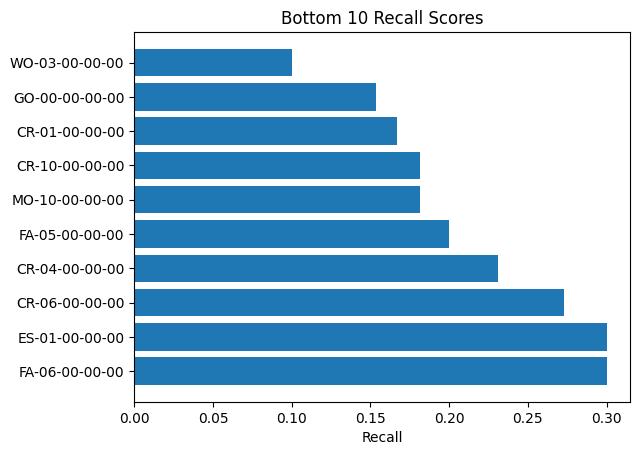

In [17]:


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0    66.67
1    87.10
2    80.19
3    84.11
4    16.67
5    23.08
6    27.27
7    18.18
8    66.67
9    83.33
10   30.00
11   30.77
12   89.92
13   20.00
14   30.00
15   58.54
16   15.38
17   86.89
18   91.82
19   70.59
20   66.67
21   77.78
22   78.96
23   33.33
24   53.85
25   18.18
26   31.82
27   81.30
28   91.54
29   68.18
30   62.07
31   47.06
32   60.00
33   74.19
34   82.95
35   10.00


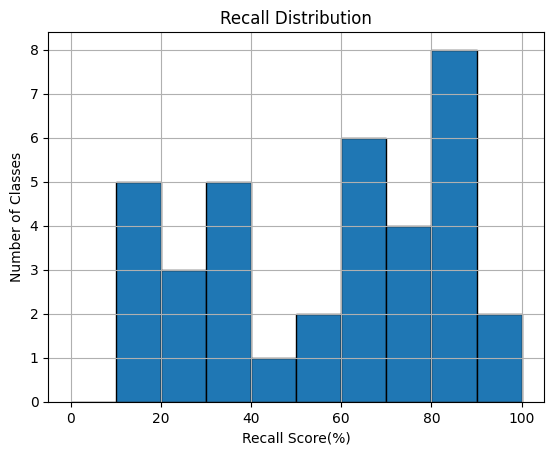

In [18]:
import pylab as pl

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

## log_loss histogram

    logloss
0    0.1996
1    0.1664
2    0.3040
3    0.3023
4    0.2066
5    0.2624
6    0.1545
7    0.1737
8    0.1264
9    0.2108
10   0.0877
11   0.2039
12   0.2564
13   0.1380
14   0.1511
15   0.3277
16   0.2298
17   0.1833
18   0.2193
19   0.2649
20   0.1763
21   0.1226
22   0.3770
23   0.1386
24   0.1040
25   0.1898
26   0.3680
27   0.3652
28   0.1918
29   0.1534
30   0.2051
31   0.1232
32   0.1333
33   0.1098
34   0.3219
35   0.2414


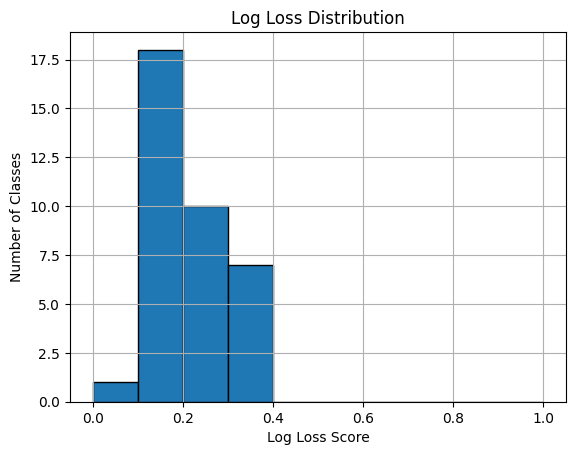

In [19]:
import pylab as pl

logloss_dict = defaultdict()
for k,v in stat_dict.items():
    logloss_dict[k] = v[5]

logloss_list = []
for k,v in logloss_dict.items():
    logloss_list.append(v)
   
d = {'logloss': logloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Log Loss Distribution")
pl.xlabel("Log Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

## Brier Score Loss

    brierloss
0      0.0532
1      0.0465
2      0.0877
3      0.0907
4      0.0540
5      0.0685
6      0.0420
7      0.0437
8      0.0290
9      0.0622
10     0.0238
11     0.0505
12     0.0758
13     0.0347
14     0.0382
15     0.0992
16     0.0556
17     0.0501
18     0.0606
19     0.0728
20     0.0459
21     0.0327
22     0.1186
23     0.0319
24     0.0295
25     0.0481
26     0.1013
27     0.1148
28     0.0525
29     0.0372
30     0.0554
31     0.0327
32     0.0287
33     0.0278
34     0.0988
35     0.0617


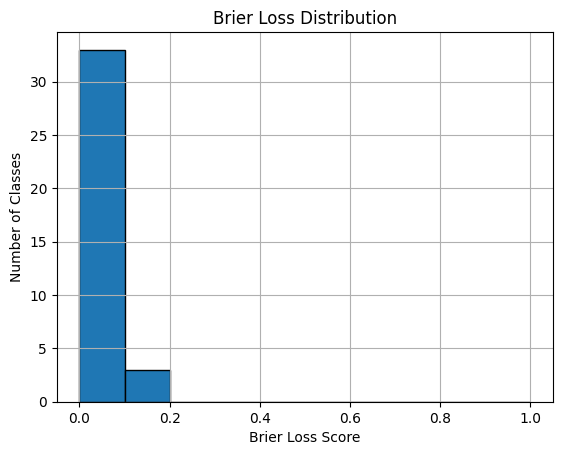

In [20]:

brierloss_dict = defaultdict()
for k,v in stat_dict.items():
    brierloss_dict[k] = v[6]

brierloss_list = []
for k,v in brierloss_dict.items():
    brierloss_list.append(v)
   
d = {'brierloss': brierloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Brier Loss Distribution")
pl.xlabel("Brier Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [21]:
#text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"
text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take? Edit: I can’t find the title. My sister was coming back home from the army and I intended on giving her the car when she arrived. I most likely left the title in the car."
print(text)
input = sent2vec(text)
input = np.array(input)

predictions = defaultdict() 
prob = defaultdict()
c_logloss = defaultdict()

for cls in class_list:
    predictions[cls] = classifier[cls].predict([input])
    prob[cls] = classifier[cls].predict_proba([input])

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k][0][1], 4))


I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take? Edit: I can’t find the title. My sister was coming back home from the army and I intended on giving her the car when she arrived. I most likely left the title in the car.
CR-00-00-00-00 [1.] 0.782
TO-00-00-00-00 [1.] 0.8144
TR-00-00-00-00 [1.] 0.9934
TR-01-00-00-00 [1.] 0.9629
TR-02-00-00-00 [1.] 0.7371
TR-03-00-00-00 [1.] 0.876
TR-04-00-00-00 [1.] 0.9989
TR-05-00-00-00 [1.] 0.6957
